# Transfer Learning: _ResNet-18_ & CIFAR-10 with PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import time, os, copy, pickle

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 2
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify hyper-parameters
batch_size = 64
num_classes = 10
num_epochs = 85

### CIFAR-10 data pre-processing

In [7]:
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(32, padding = 4),
        # transforms.RandomResizedCrop(224)
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.4914, 0.4822, 0.4465),
            std = (0.0305, 0.0296, 0.0342)
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = (0.4942, 0.4846, 0.4498),
            std = (0.0304, 0.0295, 0.0342)
        ),
     ]
)

In [8]:
train_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True,
    download = True, transform = transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root = './data', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = True
    )

In [10]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000
len(train_loader) = 782 & len(test_loader) = 157


In [11]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(781.25, 156.25)

In [12]:
def imshow(inp, title = None):
    """
    Function to visualize images. imshow() for tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4942, 0.4846, 0.4498])
    std = np.array([0.0304, 0.0295, 0.0342])
    
    # Unnormalize tensor-
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize = (12, 11))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # pause a bit so that plots are updated-
    plt.pause(0.001)
    plt.suptitle("Sample CIFAR-10 images")
    plt.show()
    
    return None


In [13]:
# Retrieve a batch of training data-
imgs, targets = next(iter(train_loader))
imgs.shape, targets.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [14]:
class_names = train_dataset.classes

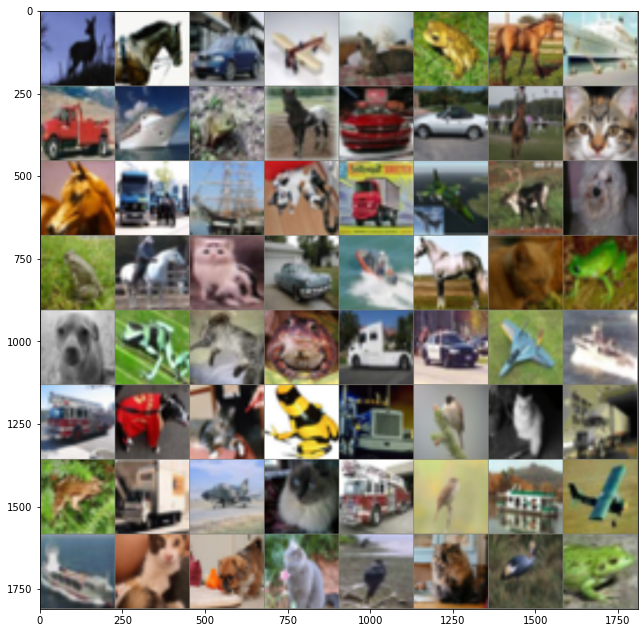

<Figure size 432x288 with 0 Axes>

In [15]:
# Make a grid from batch-
out = torchvision.utils.make_grid(imgs)

# Visualize sample images-
# imshow(out, title = [class_names[x] for x in targets])
imshow(out, title = None)

In [16]:
del imgs, targets

### Use different _ResNet_ CNN archictures for _transfer learning_

Transfer Learning strategy used involves a two-step process:

1. Feature Extraction (followed by)
1. Fine-Tuning

#### _Feature-Extraction_ 

In [17]:
def resnet18_pretrained_feature_extractor():
    '''
    Function to load pre-trained ResNet-18 for binary classification.
    Using feature extractor method.
    '''
    # Load a pre-trained ResNet18 CNN model-
    model_resnet18_fe = models.resnet18(pretrained = True)
    
    # Iterate through all trainable layers and freeze parameters-
    for param in model_resnet18_fe.parameters():
        param.requires_grad = False
    
    # Parameters of newly constructed modules have requires_grad=True by default-
    num_ftrs = model_resnet18_fe.fc.in_features
    
    # Change output layer to have two outputs-
    model_resnet18_fe.fc = nn.Linear(
        in_features = num_ftrs, out_features = len(class_names)
    )
    
    return model_resnet18_fe


In [18]:
# Initialize a pre-trained ResNet-18 CNN architecture-
model_resnet18 = resnet18_pretrained_feature_extractor()

In [19]:
tot_params = 0

# Print layer names-
for layer in model_resnet18.state_dict().keys():
    print(f"{layer} has dimension = {model_resnet18.state_dict()[layer].detach().numpy().shape}")
    tot_params += model_resnet18.state_dict()[layer].numpy().size

conv1.weight has dimension = (64, 3, 7, 7)
bn1.weight has dimension = (64,)
bn1.bias has dimension = (64,)
bn1.running_mean has dimension = (64,)
bn1.running_var has dimension = (64,)
bn1.num_batches_tracked has dimension = ()
layer1.0.conv1.weight has dimension = (64, 64, 3, 3)
layer1.0.bn1.weight has dimension = (64,)
layer1.0.bn1.bias has dimension = (64,)
layer1.0.bn1.running_mean has dimension = (64,)
layer1.0.bn1.running_var has dimension = (64,)
layer1.0.bn1.num_batches_tracked has dimension = ()
layer1.0.conv2.weight has dimension = (64, 64, 3, 3)
layer1.0.bn2.weight has dimension = (64,)
layer1.0.bn2.bias has dimension = (64,)
layer1.0.bn2.running_mean has dimension = (64,)
layer1.0.bn2.running_var has dimension = (64,)
layer1.0.bn2.num_batches_tracked has dimension = ()
layer1.1.conv1.weight has dimension = (64, 64, 3, 3)
layer1.1.bn1.weight has dimension = (64,)
layer1.1.bn1.bias has dimension = (64,)
layer1.1.bn1.running_mean has dimension = (64,)
layer1.1.bn1.running_var h

In [20]:
print(f"Total number of parameters in ResNet-18 CNN = {tot_params}")

Total number of parameters in ResNet-18 CNN = 11191262


In [21]:
# Sanity check- output layer has 10 neurons?
model_resnet18.fc

Linear(in_features=512, out_features=10, bias=True)

In [22]:
def train_model_progress(model, train_loader, lr_scheduler):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # LR decay scheduler-
            lr_scheduler.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    # train_loss = running_loss / len(train_dataset)
    train_loss = running_loss / len(train_dataset)
    # train_acc = (running_corrects.double() / len(train_dataset)) * 100
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [23]:
def test_model_progress(model, test_loader):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


### Multi-GPU Training in PyTorch

- [Multi-GPU Examples](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html)

- [Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [ ]:
# Use all available GPUs-
model_resnet18 = nn.DataParallel(model_resnet18)
model_resnet18.to(device)

#### Step-wise LR decay scheduler

Using batch-size = 64 gives 782 steps per epoch. To decay lr every 10 epochs, you get 782 x 10 = 7820 steps.

In [25]:
# Define loss function-
loss = nn.CrossEntropyLoss()

# Define SGD optimizer-
optimizer = optim.SGD(model_resnet18.parameters(), lr = 0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 10 epochs-
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7820, gamma = 0.1)

In [26]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.001

In [27]:
# Sanity check-
x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [28]:
out = model_resnet18(x)
out.shape

torch.Size([64, 10])

In [29]:
del x, y, out

In [30]:
# Python3 dict to contain training metrics-
training_history_fe_resnet18 = {}

In [31]:
# Initialize parameters saving 'best' models-
best_val_acc = 0

In [32]:
for epoch in range(20):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model_resnet18, train_loader = train_loader,
        lr_scheduler = step_lr_scheduler
    )
    val_loss, val_acc = test_model_progress(
        model = model_resnet18, test_loader = test_loader
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_fe_resnet18[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model_resnet18.state_dict(), "ResNet18_CIFAR10_best_model_feature_extractor.pth")
        

Validation: : 100%|█████████████████████████| 157/157 [00:10<00:00, 14.99batch/s, val_acc=77, val_loss=0.718]



epoch: 1 training loss = 1.0096, training accuracy = 68.61%, val_loss = 0.7182, val_accuracy = 76.96% & LR = 0.0010

Saving model with highest val_acc = 76.9600



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.97batch/s, val_acc=78.1, val_loss=0.663]



epoch: 2 training loss = 0.7111, training accuracy = 76.31%, val_loss = 0.6627, val_accuracy = 78.06% & LR = 0.0010

Saving model with highest val_acc = 78.0600



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.98batch/s, val_acc=79.2, val_loss=0.621]



epoch: 3 training loss = 0.6686, training accuracy = 77.38%, val_loss = 0.6208, val_accuracy = 79.23% & LR = 0.0010

Saving model with highest val_acc = 79.2300



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.02batch/s, val_acc=79.5, val_loss=0.609]



epoch: 4 training loss = 0.6459, training accuracy = 78.08%, val_loss = 0.6087, val_accuracy = 79.53% & LR = 0.0010

Saving model with highest val_acc = 79.5300



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.01batch/s, val_acc=79.8, val_loss=0.602]



epoch: 5 training loss = 0.6278, training accuracy = 78.46%, val_loss = 0.6017, val_accuracy = 79.76% & LR = 0.0010

Saving model with highest val_acc = 79.7600



Validation: : 100%|█████████████████████████| 157/157 [00:10<00:00, 15.09batch/s, val_acc=80, val_loss=0.593]



epoch: 6 training loss = 0.6173, training accuracy = 78.85%, val_loss = 0.5934, val_accuracy = 80.02% & LR = 0.0010

Saving model with highest val_acc = 80.0200



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.88batch/s, val_acc=79.7, val_loss=0.598]



epoch: 7 training loss = 0.6136, training accuracy = 78.89%, val_loss = 0.5975, val_accuracy = 79.68% & LR = 0.0010



Validation: : 100%|███████████████████████| 157/157 [00:11<00:00, 14.23batch/s, val_acc=79.7, val_loss=0.593]



epoch: 8 training loss = 0.6094, training accuracy = 78.91%, val_loss = 0.5927, val_accuracy = 79.68% & LR = 0.0010



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.17batch/s, val_acc=80.4, val_loss=0.578]



epoch: 9 training loss = 0.6042, training accuracy = 79.34%, val_loss = 0.5777, val_accuracy = 80.42% & LR = 0.0010

Saving model with highest val_acc = 80.4200



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.02batch/s, val_acc=80.3, val_loss=0.581]



epoch: 10 training loss = 0.6006, training accuracy = 79.38%, val_loss = 0.5806, val_accuracy = 80.30% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.06batch/s, val_acc=79.8, val_loss=0.591]



epoch: 11 training loss = 0.5881, training accuracy = 79.89%, val_loss = 0.5909, val_accuracy = 79.84% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.92batch/s, val_acc=80.6, val_loss=0.575]



epoch: 12 training loss = 0.5899, training accuracy = 79.74%, val_loss = 0.5747, val_accuracy = 80.56% & LR = 0.0001

Saving model with highest val_acc = 80.5600



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.79batch/s, val_acc=80.2, val_loss=0.589]



epoch: 13 training loss = 0.5900, training accuracy = 79.72%, val_loss = 0.5888, val_accuracy = 80.19% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.10batch/s, val_acc=80.6, val_loss=0.574]



epoch: 14 training loss = 0.5869, training accuracy = 79.87%, val_loss = 0.5735, val_accuracy = 80.63% & LR = 0.0001

Saving model with highest val_acc = 80.6300



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.11batch/s, val_acc=80.8, val_loss=0.568]



epoch: 15 training loss = 0.5876, training accuracy = 79.63%, val_loss = 0.5684, val_accuracy = 80.82% & LR = 0.0001

Saving model with highest val_acc = 80.8200



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.08batch/s, val_acc=80.7, val_loss=0.574]



epoch: 16 training loss = 0.5870, training accuracy = 79.60%, val_loss = 0.5741, val_accuracy = 80.66% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.98batch/s, val_acc=80.3, val_loss=0.575]



epoch: 17 training loss = 0.5858, training accuracy = 79.85%, val_loss = 0.5745, val_accuracy = 80.30% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.31batch/s, val_acc=80.6, val_loss=0.577]



epoch: 18 training loss = 0.5866, training accuracy = 79.89%, val_loss = 0.5773, val_accuracy = 80.61% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.87batch/s, val_acc=80.8, val_loss=0.574]



epoch: 19 training loss = 0.5866, training accuracy = 79.66%, val_loss = 0.5736, val_accuracy = 80.79% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.84batch/s, val_acc=80.5, val_loss=0.574]


epoch: 20 training loss = 0.5855, training accuracy = 79.76%, val_loss = 0.5741, val_accuracy = 80.48% & LR = 0.0000



In [34]:
print(f"LR at last epoch = {training_history_fe_resnet18[20]['lr']:.6f}")

LR at last epoch = 0.000010


### Fine-tune model

In [35]:
# Iterate through all trainable layers and freeze parameters-
for param in model_resnet18.parameters():
    param.requires_grad = True

In [36]:
# Define new GD optimizer-
optimizer = optim.SGD(model_resnet18.parameters(), lr = 10e-4, momentum = 0.9)

# Decay LR by a factor of 0.1 every 10 epochs-
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7820, gamma = 0.1)

In [37]:
# Initialize parameters saving 'best' models-
best_val_acc = 0

In [38]:
for epoch in range(20):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model_resnet18, train_loader = train_loader,
        lr_scheduler = step_lr_scheduler
    )
    val_loss, val_acc = test_model_progress(
        model = model_resnet18, test_loader = test_loader
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_fe_resnet18[epoch + 1 + 20] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model_resnet18.state_dict(), "ResNet18_CIFAR10_best_model.pth")
        

Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.17batch/s, val_acc=92.7, val_loss=0.207]



epoch: 1 training loss = 0.3143, training accuracy = 89.30%, val_loss = 0.2070, val_accuracy = 92.70% & LR = 0.0010

Saving model with highest val_acc = 92.7000



Validation: : 100%|███████████████████████| 157/157 [00:11<00:00, 14.26batch/s, val_acc=94.1, val_loss=0.168]



epoch: 2 training loss = 0.1730, training accuracy = 94.03%, val_loss = 0.1679, val_accuracy = 94.06% & LR = 0.0010

Saving model with highest val_acc = 94.0600



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.91batch/s, val_acc=94.6, val_loss=0.164]



epoch: 3 training loss = 0.1196, training accuracy = 96.04%, val_loss = 0.1643, val_accuracy = 94.59% & LR = 0.0010

Saving model with highest val_acc = 94.5900



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.07batch/s, val_acc=95.1, val_loss=0.147]



epoch: 4 training loss = 0.0897, training accuracy = 97.04%, val_loss = 0.1472, val_accuracy = 95.14% & LR = 0.0010

Saving model with highest val_acc = 95.1400



Validation: : 100%|██████████████████████████| 157/157 [00:11<00:00, 14.26batch/s, val_acc=95, val_loss=0.15]



epoch: 5 training loss = 0.0673, training accuracy = 97.87%, val_loss = 0.1498, val_accuracy = 94.96% & LR = 0.0010



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.12batch/s, val_acc=95.1, val_loss=0.148]



epoch: 6 training loss = 0.0539, training accuracy = 98.38%, val_loss = 0.1480, val_accuracy = 95.13% & LR = 0.0010



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.02batch/s, val_acc=95.5, val_loss=0.136]



epoch: 7 training loss = 0.0417, training accuracy = 98.77%, val_loss = 0.1362, val_accuracy = 95.54% & LR = 0.0010

Saving model with highest val_acc = 95.5400



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.81batch/s, val_acc=95.6, val_loss=0.139]



epoch: 8 training loss = 0.0322, training accuracy = 99.14%, val_loss = 0.1385, val_accuracy = 95.61% & LR = 0.0010

Saving model with highest val_acc = 95.6100



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.50batch/s, val_acc=95.4, val_loss=0.141]



epoch: 9 training loss = 0.0268, training accuracy = 99.32%, val_loss = 0.1409, val_accuracy = 95.44% & LR = 0.0010



Validation: : 100%|████████████████████████| 157/157 [00:10<00:00, 15.15batch/s, val_acc=95.7, val_loss=0.14]



epoch: 10 training loss = 0.0229, training accuracy = 99.43%, val_loss = 0.1395, val_accuracy = 95.73% & LR = 0.0001

Saving model with highest val_acc = 95.7300



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.87batch/s, val_acc=95.7, val_loss=0.135]



epoch: 11 training loss = 0.0179, training accuracy = 99.59%, val_loss = 0.1352, val_accuracy = 95.74% & LR = 0.0001

Saving model with highest val_acc = 95.7400



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.13batch/s, val_acc=95.9, val_loss=0.134]



epoch: 12 training loss = 0.0149, training accuracy = 99.70%, val_loss = 0.1344, val_accuracy = 95.89% & LR = 0.0001

Saving model with highest val_acc = 95.8900



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.00batch/s, val_acc=95.8, val_loss=0.134]



epoch: 13 training loss = 0.0154, training accuracy = 99.68%, val_loss = 0.1343, val_accuracy = 95.78% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.06batch/s, val_acc=95.8, val_loss=0.136]



epoch: 14 training loss = 0.0143, training accuracy = 99.75%, val_loss = 0.1364, val_accuracy = 95.76% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.47batch/s, val_acc=95.9, val_loss=0.134]



epoch: 15 training loss = 0.0140, training accuracy = 99.71%, val_loss = 0.1343, val_accuracy = 95.87% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.09batch/s, val_acc=95.9, val_loss=0.135]



epoch: 16 training loss = 0.0130, training accuracy = 99.75%, val_loss = 0.1355, val_accuracy = 95.85% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.12batch/s, val_acc=95.9, val_loss=0.136]



epoch: 17 training loss = 0.0129, training accuracy = 99.77%, val_loss = 0.1356, val_accuracy = 95.87% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 14.69batch/s, val_acc=95.8, val_loss=0.136]



epoch: 18 training loss = 0.0125, training accuracy = 99.80%, val_loss = 0.1356, val_accuracy = 95.80% & LR = 0.0001



Validation: : 100%|███████████████████████| 157/157 [00:10<00:00, 15.13batch/s, val_acc=95.9, val_loss=0.135]



epoch: 19 training loss = 0.0130, training accuracy = 99.75%, val_loss = 0.1352, val_accuracy = 95.92% & LR = 0.0001

Saving model with highest val_acc = 95.9200



Validation: : 100%|█████████████████████████| 157/157 [00:10<00:00, 15.03batch/s, val_acc=96, val_loss=0.133]



epoch: 20 training loss = 0.0123, training accuracy = 99.78%, val_loss = 0.1331, val_accuracy = 96.05% & LR = 0.0000

Saving model with highest val_acc = 96.0500



In [43]:
with open("ResNet18_transfer_learning_CIFAR10.pickle", "wb") as file:
    pickle.dump(training_history_fe_resnet18, file)

### _Transfer Learning_ Training Visualizations

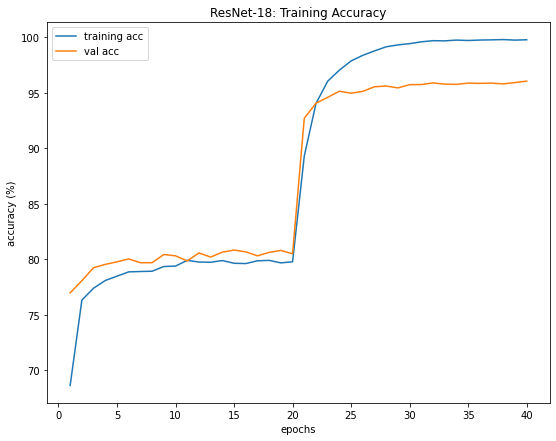

In [39]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_fe_resnet18.keys()), [training_history_fe_resnet18[k]['acc'] for k in training_history_fe_resnet18.keys()], label = 'training acc')
plt.plot(list(training_history_fe_resnet18.keys()), [training_history_fe_resnet18[k]['val_acc'] for k in training_history_fe_resnet18.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

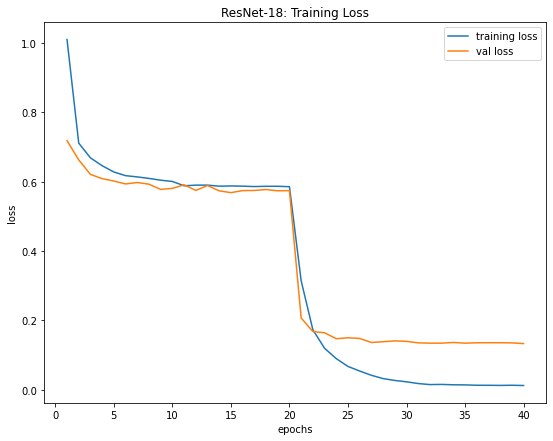

In [40]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_fe_resnet18.keys()), [training_history_fe_resnet18[k]['loss'] for k in training_history_fe_resnet18.keys()], label = 'training loss')
plt.plot(list(training_history_fe_resnet18.keys()), [training_history_fe_resnet18[k]['val_loss'] for k in training_history_fe_resnet18.keys()], label = 'val loss')
plt.title("ResNet-18: Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

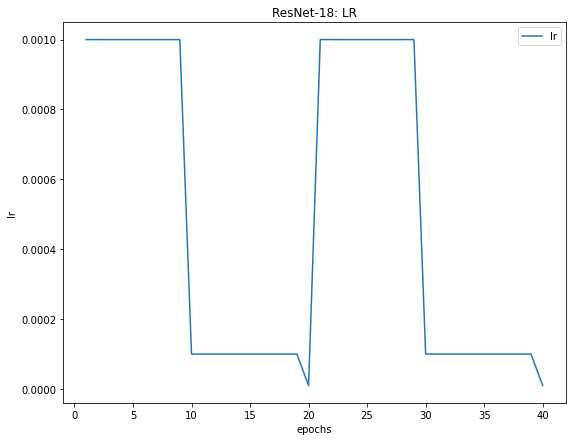

In [41]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_fe_resnet18.keys()), [training_history_fe_resnet18[k]['lr'] for k in training_history_fe_resnet18.keys()], label = 'lr')
plt.title("ResNet-18: LR")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.legend(loc = 'best')
plt.show()